# LSTM Stock Predictor Using Closing Prices
In this notebook, we will build and train a custom LSTM RNN that uses a 10 day window of Stock closing prices to predict the 11th day closing price.

You will need to:

Prepare the data for training and testing
Build and train a custom LSTM RNN
Evaluate the performance of the model
Data Preparation
In this section, we will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:

Use the window_data function to generate the X and y values for the model.
Split the data into 70% training and 30% testing
Apply the MinMaxScaler to the X and y values
Reshape the X_train and X_test data for the model.

In [1]:
pip install hvplot

     |████████████████████████████████| 3.1 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.0 MB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 240 kB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 17.7 MB/s eta 0:00:011
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

panel 0.11.3 requires bokeh<2.4.0,>=2.3.0, but you'll have bokeh 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import HoverTool

In [3]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# Load the historical closing prices for Bitcoin
amzn_df = pd.read_csv('amzn_closing_prices.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
amzn_df = amzn_df.sort_index()
amzn_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700
...,...,...,...,...,...,...
2021-05-24,3215.500000,3257.949951,3210.500000,3244.989990,3244.989990,2422800
2021-05-25,3266.669922,3279.820068,3213.760010,3259.050049,3259.050049,3261100
2021-05-26,3274.590088,3295.729980,3258.510010,3265.159912,3265.159912,2384000


In [5]:
amzn_closing_df = amzn_df['Close'].reset_index()
amzn_closing_df = amzn_closing_df.set_index('Date')
amzn_closing_df.head()

,Close
Date,
2011-01-03,184.220001
2011-01-04,185.009995
2011-01-05,187.419998
2011-01-06,185.860001
2011-01-07,185.490005


In [6]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(stock_closing_df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(amzn_closing_df) - window - 1):
        features = amzn_closing_df.iloc[i:(i + window), feature_col_number]
        target = amzn_closing_df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [7]:
# Predict Closing Prices using a 10 day window of previous closing prices
window_size = 10

# Column index 0, is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(amzn_closing_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:10]} \n")
print (f"y sample values:\n{y[:10]}")

X sample values:
[[184.22000122 185.00999451 187.41999817 185.86000061 185.49000549
  184.67999268 184.33999634 184.08000183 185.52999878 188.75      ]
 [185.00999451 187.41999817 185.86000061 185.49000549 184.67999268
  184.33999634 184.08000183 185.52999878 188.75       191.25      ]
 [187.41999817 185.86000061 185.49000549 184.67999268 184.33999634
  184.08000183 185.52999878 188.75       191.25       186.86999512]
 [185.86000061 185.49000549 184.67999268 184.33999634 184.08000183
  185.52999878 188.75       191.25       186.86999512 181.96000671]
 [185.49000549 184.67999268 184.33999634 184.08000183 185.52999878
  188.75       191.25       186.86999512 181.96000671 177.41999817]
 [184.67999268 184.33999634 184.08000183 185.52999878 188.75
  191.25       186.86999512 181.96000671 177.41999817 176.8500061 ]
 [184.33999634 184.08000183 185.52999878 188.75       191.25
  186.86999512 181.96000671 177.41999817 176.8500061  176.69999695]
 [184.08000183 185.52999878 188.75       191.25   

In [8]:
# Use 70% of the data for training and the remaineder for testing
split_data = int(0.7 * len(X))

X_train = X[:split_data - 1]
X_test = X[split_data:]

y_train = y[:split_data - 1]
y_test = y[split_data:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# Create a MinMaxScaler object
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [10]:
X_train

array([[0.01617481, 0.0167244 , 0.01840102, ..., 0.01607742, 0.01708617,
        0.01932629],
       [0.0167244 , 0.01840102, 0.01731575, ..., 0.01708617, 0.01932629,
        0.02106552],
       [0.01840102, 0.01731575, 0.01705834, ..., 0.01932629, 0.02106552,
        0.01801839],
       ...,
       [0.89491586, 0.84249557, 0.85645117, ..., 0.88717978, 0.88080035,
        0.89572288],
       [0.84249557, 0.85645117, 0.86933529, ..., 0.88080035, 0.89572288,
        0.88340222],
       [0.85645117, 0.86933529, 0.89798388, ..., 0.89572288, 0.88340222,
        0.89085305]])

In [11]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.01617481]
  [0.0167244 ]
  [0.01840102]
  [0.01731575]
  [0.01705834]
  [0.01649482]
  [0.01625829]
  [0.01607742]
  [0.01708617]
  [0.01932629]]

 [[0.0167244 ]
  [0.01840102]
  [0.01731575]
  [0.01705834]
  [0.01649482]
  [0.01625829]
  [0.01607742]
  [0.01708617]
  [0.01932629]
  [0.02106552]]

 [[0.01840102]
  [0.01731575]
  [0.01705834]
  [0.01649482]
  [0.01625829]
  [0.01607742]
  [0.01708617]
  [0.01932629]
  [0.02106552]
  [0.01801839]]

 [[0.01731575]
  [0.01705834]
  [0.01649482]
  [0.01625829]
  [0.01607742]
  [0.01708617]
  [0.01932629]
  [0.02106552]
  [0.01801839]
  [0.01460256]]

 [[0.01705834]
  [0.01649482]
  [0.01625829]
  [0.01607742]
  [0.01708617]
  [0.01932629]
  [0.02106552]
  [0.01801839]
  [0.01460256]
  [0.01144411]]] 

X_test sample values:
[[[0.04927567]
  [0.02800928]
  [0.02839784]
  [0.0421762 ]
  [0.03798421]
  [0.04778995]
  [0.03969393]
  [0.04458994]
  [0.07308376]
  [0.08405982]]

 [[0.02800928]
  [0.02839784]
  [0.042176

## Build and Train the LSTM RNN
In this section, we will design a custom LSTM RNN and fit (train) it using the training data.

We will need to:

Define the model architecture
Compile the model
Fit the model to the training data

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [13]:
# Define the LSTM RNN model
model = Sequential()

# Initial model setup
number_units = 10
dropout_fraction = 0.3

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units=number_units, 
    return_sequences=True)
    )
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units=number_units)
    )
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [14]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
# Summarize the model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 10)            480       
_________________________________________________________________
dropout (Dropout)            (None, 10, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [16]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
1824/1824 [==============================] - 17s 7ms/step - loss: 0.0011
Epoch 2/10
1824/1824 [==============================] - 14s 8ms/step - loss: 0.0072
Epoch 3/10
1824/1824 [==============================] - 14s 7ms/step - loss: 0.0062
Epoch 4/10
1824/1824 [==============================] - 14s 8ms/step - loss: 0.0036
Epoch 5/10
1824/1824 [==============================] - 14s 7ms/step - loss: 0.0034
Epoch 6/10
1824/1824 [==============================] - 14s 8ms/step - loss: 0.0034
Epoch 7/10
1824/1824 [==============================] - 14s 7ms/step - loss: 0.0030
Epoch 8/10
1824/1824 [==============================] - 15s 8ms/step - loss: 0.0032
Epoch 9/10
1824/1824 [==============================] - 14s 8ms/step - loss: 0.0034
Epoch 10/10
1824/1824 [==============================] - 14s 8ms/step - loss: 0.0029


## Model Performance
In this section, you will evaluate the model using the test data.

You will need to:

Evaluate the model using the X_test and y_test data.
Use the X_test data to make predictions
Create a DataFrame of Real (y_test) vs predicted values.
Plot the Real vs predicted values as a line chart


In [17]:
# Evaluate the model
model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 3ms/step - loss: 0.0594


0.05935908481478691

In [18]:
# Make some predictions
predicted = model.predict(X_test)

In [19]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
actual_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Create a DataFrame of Real and Predicted values
amzn_stocks = pd.DataFrame({
    "Actual": actual_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = amzn_closing_df.index[-len(actual_prices): ]) 
amzn_stocks.head()

,Actual,Predicted
Date,,
2018-04-20,1556.910034,2109.520508
2018-04-23,1527.489990,2112.161133
2018-04-24,1517.859985,2117.098389
2018-04-25,1460.089966,2122.405029
2018-04-26,1460.170044,2126.054199


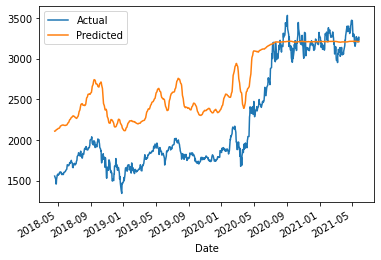

In [22]:
amzn_stocks.plot()